<a href="https://colab.research.google.com/github/GusdPaula/ML_interview/blob/main/tensor_flow_interview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [87]:
# Load data
dataset_name = 'cifar10'
(train_dataset, test_dataset), dataset_info = tfds.load(name=dataset_name,
                                                       split=['train', 'test'],
                                                       shuffle_files=True,
                                                       with_info=True,
                                                       as_supervised=True)

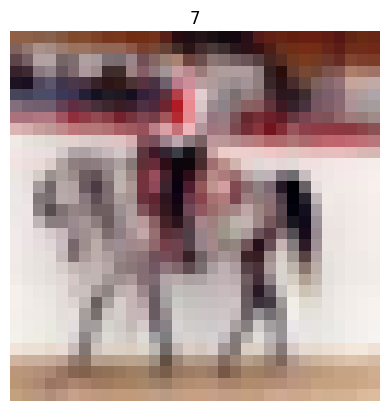

In [88]:
image, label = next(iter(train_dataset.take(1)))

plt.imshow(image)
plt.title(label.numpy())
plt.axis('off')
plt.show()

In [89]:
# Get the number of classes in the dataset
num_classes = dataset_info.features['label'].num_classes
num_classes

10

In [90]:
# Preprocess the data
def preprocess_data(image, label):
    # Convert image to float32 and normalize between 0 and 1
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [91]:
# Apply preprocessing to the datasets
test_dataset = test_dataset.map(preprocess_data)

In [92]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),           # flip left-right
    tf.keras.layers.RandomRotation(0.1),                # rotate ±10%
    tf.keras.layers.RandomZoom(0.1),                    # zoom in/out
    tf.keras.layers.RandomContrast(0.1),                # adjust contrast
])

In [93]:
def augment(image, label):
    image = data_augmentation(image)
    return image, label

In [94]:
train_dataset = (train_dataset
            .map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
            .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(10000)
            .batch(64)
            .prefetch(tf.data.AUTOTUNE))

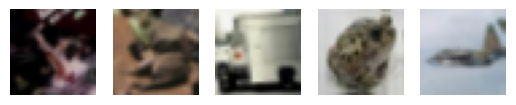

In [95]:

for image, label in train_dataset.take(1):
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(image[i])
        plt.axis('off')
    plt.show()

In [96]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [97]:
# Step 3: Build the model
input_dim = (32, 32, 3)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_dim),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
# Print the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

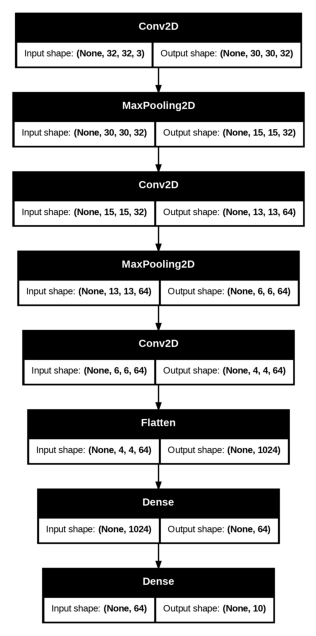

In [98]:
import matplotlib.image as mpimg
#Generate the model graph
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True)

# Use matplotlib to display with custom size
img = mpimg.imread('model_plot.png')
plt.figure(figsize=(12, 8))  # Change width, height here
plt.imshow(img)
plt.axis('off')
plt.show()

In [99]:
#Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [100]:
batch_size = 128
num_epochs = 10
# To process the dataset in batches create the batches of batch_size
test_dataset = test_dataset.batch(batch_size)

#Train the model
model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.3013 - loss: 1.8811

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


782/782 ━━━━━━━━━━━━━━━━━━━━ 113s 132ms/step - accuracy: 0.3015 - loss: 1.8806 - val_accuracy: 0.4760 - val_loss: 1.4282
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 95s 116ms/step - accuracy: 0.4838 - loss: 1.4317 - val_accuracy: 0.5318 - val_loss: 1.3110
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 93s 112ms/step - accuracy: 0.5309 - loss: 1.3089 - val_accuracy: 0.5577 - val_loss: 1.2686
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 96s 116ms/step - accuracy: 0.5643 - loss: 1.2260 - val_accuracy: 0.5988 - val_loss: 1.1315
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 115ms/step - accuracy: 0.5877 - loss: 1.1631 - val_accuracy: 0.6215 - val_loss: 1.0696
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 116ms/step - accuracy: 0.6061 - loss: 1.1221 - val_accuracy: 0.6116 - val_loss: 1.1055
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 115ms/step - accuracy: 0.6192 - loss: 1.0929 - val_accuracy: 0.6202 - val_loss: 1.0876
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 93s 114ms/step - accuracy: 0.6281 - loss: 1.0642 -

In [101]:
# Step 7: Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6661 - loss: 0.9676
Test loss: 0.9681993126869202
Test accuracy: 0.6622999906539917


In [102]:

# create a custom array of image size
new_image = tf.constant(np.random.rand(32, 32, 3), dtype=tf.float64)
# Extend the dimension 4D
new_image = tf.expand_dims(new_image, axis=0)

# Prediction
predictions = model.predict(new_image)
# predicted label
pred_label = tf.argmax(predictions, axis =1)
pred_label.numpy()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


array([1])

In [103]:
# Step 1: Get one batch (typically a tuple of (images, labels))
for images, labels in test_dataset.take(2):
    one_image = images[0]        # shape: (height, width, channels)
    true_label = labels[0]       # optional, just to compare

# Step 2: Expand dimensions to simulate a batch of 1
one_image_expanded = tf.expand_dims(one_image, axis=0)  # shape: (1, height, width, channels)

# Step 3: Predict
predictions = model.predict(one_image_expanded)  # shape: (1, num_classes)

# Step 4: Get predicted class
predicted_class = tf.argmax(predictions[0]).numpy()

# Optional: Print result
print("Predicted class:", predicted_class)
print("True label:", true_label.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted class: 9
True label: 9


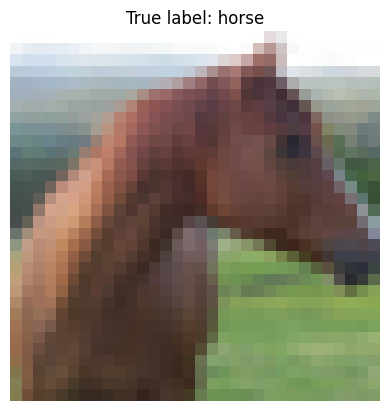

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted class: horse


In [104]:
# Suppose you have a list of class names in order (like for CIFAR-10 or MNIST)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']  # <-- Replace with your dataset's labels

# Step 1: Get one image and label from the dataset
for images, labels in test_dataset.take(1):  # Takes 1 batch
    image = images[6]     # shape: (height, width, channels)
    label = labels[6]     # true label (number)
    break

# Step 2: Show the image
plt.imshow(image.numpy())
plt.axis("off")
plt.title(f"True label: {class_names[label.numpy()]}")
plt.show()

# Step 3: Prepare image for prediction (add batch dimension)
image_batch = tf.expand_dims(image, axis=0)  # shape becomes (1, height, width, channels)

# Step 4: Predict
pred = model.predict(image_batch)
predicted_class = tf.argmax(pred[0]).numpy()

# Step 5: Show prediction
print("Predicted class:", class_names[predicted_class])